# Wine No Partial - Unsupervised Gradient Analysis

**Goal**: Explore unsupervised methods to separate correct from incorrect hypotheses
using gradient information, WITHOUT relying on partial data labels.

**Key Insight**: Correct and incorrect gradients have ~-0.96 cosine similarity.
Can we exploit this separation without knowing which is which?

In [10]:
# Imports and Setup
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from GGH.data_ops import DataOperator

# Deterministic setup
def set_to_deterministic(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_to_deterministic(0)
print("Imports successful!")

Imports successful!


In [11]:
# Configuration
data_path = '../data/wine/red_wine.csv'
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid']
target_vars = ['quality']
miss_vars = ['alcohol']
hypothesis = [[9.4, 10.5, 12.0]]  # 3 hypothesis values

# Training parameters
partial_perc = 0.025  # 2.5% - but we won't use it for selection
rand_state = 0
batch_size = 64
lr = 0.001
hidden_size = 32
output_size = len(target_vars)

# Phase 1 parameters
phase1_epochs = 60  # Best from experiments
phase1_analysis_epochs = 10  # Track last N epochs

print(f"Hypothesis values: {hypothesis[0]}")
print(f"Phase 1: {phase1_epochs} epochs (track last {phase1_analysis_epochs})")

Hypothesis values: [9.4, 10.5, 12.0]
Phase 1: 60 epochs (track last 10)


In [12]:
# Model Definitions (reused from Wine_Hybrid)

class HypothesisAmplifyingModel(nn.Module):
    """Model that amplifies hypothesis feature impact on gradients."""
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared feature pathway (smaller)
        self.shared_net = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
            nn.Linear(shared_hidden, shared_hidden),
            nn.ReLU()
        )
        
        # Hypothesis pathway (larger - amplified)
        self.hypothesis_net = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU()
        )
        
        # Final combination
        self.final_net = nn.Sequential(
            nn.Linear(shared_hidden + hypothesis_hidden, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
    def forward(self, shared_features, hypothesis_features):
        shared_out = self.shared_net(shared_features)
        hyp_out = self.hypothesis_net(hypothesis_features)
        combined = torch.cat([shared_out, hyp_out], dim=1)
        return self.final_net(combined)


class Phase1Dataset(torch.utils.data.Dataset):
    def __init__(self, DO):
        input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
        self.inputs = torch.tensor(
            DO.df_train_hypothesis[input_cols].values,
            dtype=torch.float32
        )
        self.targets = torch.tensor(
            DO.df_train_hypothesis[DO.target_vars].values,
            dtype=torch.float32
        )
        self.global_ids = torch.arange(len(DO.df_train_hypothesis))
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.global_ids[idx]


class Phase1Trainer:
    def __init__(self, DO, model, lr=0.001):
        self.DO = DO
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        self.model.train()
        total_loss = 0
        
        for batch_x, batch_y, batch_gids in dataloader:
            self.optimizer.zero_grad()
            
            shared = batch_x[:, :len(self.DO.inpt_vars)]
            hyp = batch_x[:, len(self.DO.inpt_vars):]
            
            pred = self.model(shared, hyp)
            losses = self.criterion(pred, batch_y)
            loss = losses.mean()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            
            if track_data:
                with torch.no_grad():
                    for i, gid in enumerate(batch_gids.tolist()):
                        if gid not in self.loss_history:
                            self.loss_history[gid] = []
                        self.loss_history[gid].append(losses[i].mean().item())
        
        if track_data:
            self._compute_gradients(dataloader)
        
        return total_loss / len(dataloader)
    
    def _compute_gradients(self, dataloader):
        self.model.eval()
        params = list(self.model.hypothesis_net.parameters())
        
        for batch_x, batch_y, batch_gids in dataloader:
            shared = batch_x[:, :len(self.DO.inpt_vars)]
            hyp = batch_x[:, len(self.DO.inpt_vars):]
            
            for i in range(len(batch_x)):
                gid = batch_gids[i].item()
                
                pred = self.model(shared[i:i+1], hyp[i:i+1])
                loss = self.criterion(pred, batch_y[i:i+1]).mean()
                
                grad_param = grad(loss, params[-2], retain_graph=False)[0]
                grad_vec = grad_param.flatten().detach().cpu().numpy()
                
                if gid not in self.gradient_history:
                    self.gradient_history[gid] = []
                self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_history': self.gradient_history.get(gid, []),
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("Model classes defined.")

Model classes defined.


In [13]:
# Initialize Data
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                  partial_perc, rand_state, device='cpu')
DO.problem_type = 'regression'

hyp_per_sample = DO.num_hyp_comb
n_samples = len(DO.df_train_hypothesis) // hyp_per_sample

print(f"Total hypotheses: {len(DO.df_train_hypothesis)}")
print(f"Samples: {n_samples}")
print(f"Hypotheses per sample: {hyp_per_sample}")
print(f"Correct hypotheses: {DO.df_train_hypothesis['correct_hypothesis'].sum()} ({100/hyp_per_sample:.1f}%)")

Total hypotheses: 3453
Samples: 1151
Hypotheses per sample: 3
Correct hypotheses: 1151 (33.3%)


In [14]:
# Phase 1: Train model and collect gradients
print("="*60)
print("PHASE 1: Training to collect gradients")
print("="*60)

phase1_dataset = Phase1Dataset(DO)
phase1_dataloader = torch.utils.data.DataLoader(
    phase1_dataset, batch_size=batch_size, shuffle=True
)

model = HypothesisAmplifyingModel(
    n_shared_features=len(inpt_vars),
    n_hypothesis_features=1,
    shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
    output_size=output_size
)

trainer = Phase1Trainer(DO, model, lr=lr)

for epoch in tqdm(range(phase1_epochs)):
    track = epoch >= (phase1_epochs - phase1_analysis_epochs)
    loss = trainer.train_epoch(phase1_dataloader, epoch, track_data=track)

print(f"\nPhase 1 complete. Tracked {len(trainer.gradient_history)} hypotheses.")
print(f"Epochs tracked per hypothesis: {len(list(trainer.gradient_history.values())[0])}")

PHASE 1: Training to collect gradients


100%|██████████| 60/60 [00:17<00:00,  3.40it/s]


Phase 1 complete. Tracked 3453 hypotheses.
Epochs tracked per hypothesis: 10



PCA VISUALIZATION - 10 epochs averaged, GRADIENTS ONLY
Analyzing 3453 vectors (Gradients Only, averaged over last 10 epochs)
Vector dimension: 1024
Correct: 1151, Incorrect: 2302


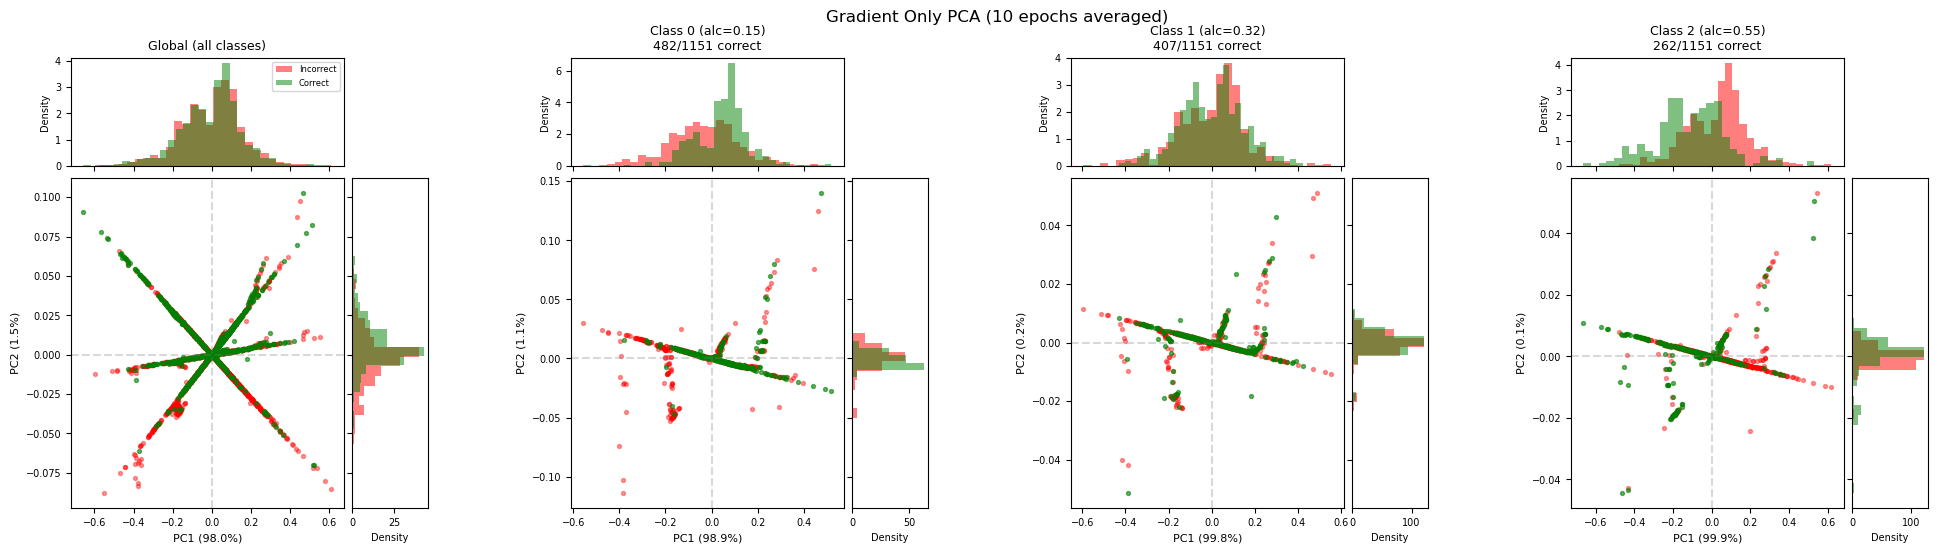


SEPARATION STATISTICS

Global:
  Cosine similarity (correct vs incorrect means): -0.9885
  Correct gradient std: 0.0016
  Incorrect gradient std: 0.0016

Per-class:
  Class 0: cosine_sim = -0.9999
  Class 1: cosine_sim = -0.6815
  Class 2: cosine_sim = -0.9999

PCA VISUALIZATION - 10 epochs averaged, GRADIENTS + CONTEXT
Analyzing 3453 vectors (Gradients + Context, averaged over last 10 epochs)
Vector dimension: 1028
Correct: 1151, Incorrect: 2302


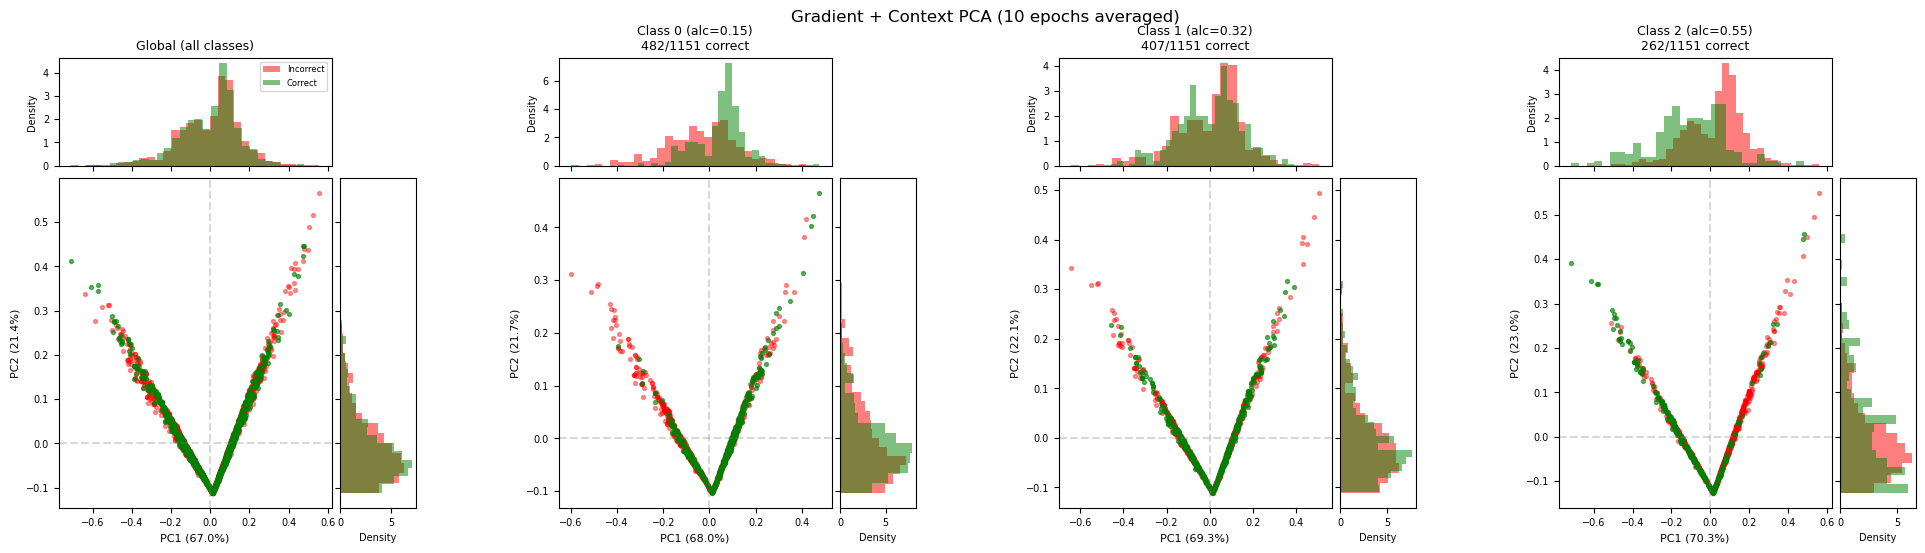


SEPARATION STATISTICS

Global:
  Cosine similarity (correct vs incorrect means): 0.9942
  Correct gradient std: 0.0018
  Incorrect gradient std: 0.0018

Per-class:
  Class 0: cosine_sim = 0.7112
  Class 1: cosine_sim = 0.9992
  Class 2: cosine_sim = 0.6505


In [15]:
# =============================================================================
# PCA VISUALIZATION OF GRADIENTS (with and without context)
# =============================================================================
from matplotlib.gridspec import GridSpec

def visualize_gradient_pca(trainer, DO, n_epochs_to_average=10, include_context=False, figsize=(20, 6)):
    """
    Visualize gradients in PCA space with marginal histograms.
    
    Args:
        trainer: Phase1Trainer with gradient_history
        DO: DataOperator
        n_epochs_to_average: Number of recent epochs to average for each gradient
        include_context: If True, concatenate input features to gradient vector
    """
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
    
    # Collect gradients and labels
    gradients = []
    is_correct = []
    class_ids = []
    gids = []
    
    for gid, grad_list in trainer.gradient_history.items():
        if len(grad_list) < n_epochs_to_average:
            continue
        
        avg_grad = np.mean(grad_list[-n_epochs_to_average:], axis=0)
        
        if include_context:
            context = DO.df_train_hypothesis.iloc[gid][input_cols].values.astype(np.float32)
            context_normalized = context / (np.linalg.norm(context) + 1e-8) * np.linalg.norm(avg_grad)
            avg_grad = np.concatenate([avg_grad, context_normalized])
        
        gradients.append(avg_grad)
        is_correct.append(DO.df_train_hypothesis.iloc[gid]['correct_hypothesis'])
        class_ids.append(DO.df_train_hypothesis.iloc[gid]['hyp_class_id'])
        gids.append(gid)
    
    gradients = np.array(gradients)
    is_correct = np.array(is_correct)
    class_ids = np.array(class_ids)
    
    context_str = " + Context" if include_context else " Only"
    print(f"Analyzing {len(gradients)} vectors (Gradients{context_str}, averaged over last {n_epochs_to_average} epochs)")
    print(f"Vector dimension: {gradients.shape[1]}")
    print(f"Correct: {is_correct.sum()}, Incorrect: {(~is_correct).sum()}")
    
    hyp_values = DO.hypothesis[0] if hasattr(DO, 'hypothesis') else hypothesis[0]
    
    # Create figure with subplots for each class + global
    n_plots = hyp_per_sample + 1
    fig = plt.figure(figsize=figsize)
    
    # For each plot (global + per-class)
    for plot_idx in range(n_plots):
        if plot_idx == 0:
            # Global plot
            mask = np.ones(len(gradients), dtype=bool)
            title = "Global (all classes)"
        else:
            # Per-class plot
            class_id = plot_idx - 1
            mask = class_ids == class_id
            hyp_val = hyp_values[class_id]
            n_correct = is_correct[mask].sum()
            n_total = mask.sum()
            title = f"Class {class_id} (alc={hyp_val:.2f})\n{n_correct}/{n_total} correct"
        
        if mask.sum() == 0:
            continue
        
        plot_grads = gradients[mask]
        plot_correct = is_correct[mask]
        
        # PCA for this subset
        pca_sub = PCA(n_components=2)
        grads_2d = pca_sub.fit_transform(plot_grads)
        
        correct_2d = grads_2d[plot_correct]
        incorrect_2d = grads_2d[~plot_correct]
        
        # Create subplot with marginal histograms using GridSpec
        # Position: each plot takes 1/(n_plots) of the width
        left = plot_idx / n_plots + 0.02
        width = 1 / n_plots - 0.04
        
        # Main scatter plot
        ax_scatter = fig.add_axes([left + 0.08*width, 0.15, 0.65*width, 0.55])
        # Top histogram (PC1)
        ax_hist_top = fig.add_axes([left + 0.08*width, 0.72, 0.65*width, 0.18], sharex=ax_scatter)
        # Right histogram (PC2)
        ax_hist_right = fig.add_axes([left + 0.75*width, 0.15, 0.18*width, 0.55], sharey=ax_scatter)
        
        # Scatter plot
        ax_scatter.scatter(incorrect_2d[:, 0], incorrect_2d[:, 1], c='red', alpha=0.4, s=8, label='Incorrect')
        ax_scatter.scatter(correct_2d[:, 0], correct_2d[:, 1], c='green', alpha=0.6, s=8, label='Correct')
        ax_scatter.set_xlabel(f'PC1 ({pca_sub.explained_variance_ratio_[0]*100:.1f}%)', fontsize=8)
        ax_scatter.set_ylabel(f'PC2 ({pca_sub.explained_variance_ratio_[1]*100:.1f}%)', fontsize=8)
        ax_scatter.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax_scatter.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
        ax_scatter.tick_params(labelsize=7)
        
        # Top histogram (PC1 distribution)
        bins = 30
        ax_hist_top.hist(incorrect_2d[:, 0], bins=bins, alpha=0.5, color='red', density=True, label='Incorrect')
        ax_hist_top.hist(correct_2d[:, 0], bins=bins, alpha=0.5, color='green', density=True, label='Correct')
        ax_hist_top.set_title(title, fontsize=9)
        ax_hist_top.tick_params(labelbottom=False, labelsize=7)
        ax_hist_top.set_ylabel('Density', fontsize=7)
        if plot_idx == 0:
            ax_hist_top.legend(fontsize=6, loc='upper right')
        
        # Right histogram (PC2 distribution)
        ax_hist_right.hist(incorrect_2d[:, 1], bins=bins, alpha=0.5, color='red', density=True, orientation='horizontal')
        ax_hist_right.hist(correct_2d[:, 1], bins=bins, alpha=0.5, color='green', density=True, orientation='horizontal')
        ax_hist_right.tick_params(labelleft=False, labelsize=7)
        ax_hist_right.set_xlabel('Density', fontsize=7)
    
    plt.suptitle(f'Gradient{context_str} PCA ({n_epochs_to_average} epochs averaged)', fontsize=12, y=0.98)
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("SEPARATION STATISTICS")
    print("="*60)
    
    correct_grads = gradients[is_correct]
    incorrect_grads = gradients[~is_correct]
    
    correct_mean = np.mean(correct_grads, axis=0)
    incorrect_mean = np.mean(incorrect_grads, axis=0)
    
    cosine_sim = np.dot(correct_mean, incorrect_mean) / (
        np.linalg.norm(correct_mean) * np.linalg.norm(incorrect_mean) + 1e-8
    )
    
    print(f"\nGlobal:")
    print(f"  Cosine similarity (correct vs incorrect means): {cosine_sim:.4f}")
    print(f"  Correct gradient std: {np.mean(np.std(correct_grads, axis=0)):.4f}")
    print(f"  Incorrect gradient std: {np.mean(np.std(incorrect_grads, axis=0)):.4f}")
    
    print(f"\nPer-class:")
    for class_id in range(hyp_per_sample):
        mask = class_ids == class_id
        class_grads = gradients[mask]
        class_correct = is_correct[mask]
        
        if class_correct.sum() > 0 and (~class_correct).sum() > 0:
            c_mean = np.mean(class_grads[class_correct], axis=0)
            i_mean = np.mean(class_grads[~class_correct], axis=0)
            sim = np.dot(c_mean, i_mean) / (np.linalg.norm(c_mean) * np.linalg.norm(i_mean) + 1e-8)
            print(f"  Class {class_id}: cosine_sim = {sim:.4f}")
    
    return gradients, is_correct, class_ids, None

# Run visualization - GRADIENTS ONLY (10 epochs)
print("\n" + "="*70)
print("PCA VISUALIZATION - 10 epochs averaged, GRADIENTS ONLY")
print("="*70)
gradients, is_correct, class_ids, _ = visualize_gradient_pca(trainer, DO, n_epochs_to_average=10, include_context=False)

# Run visualization - GRADIENTS + CONTEXT (10 epochs)
print("\n" + "="*70)
print("PCA VISUALIZATION - 10 epochs averaged, GRADIENTS + CONTEXT")
print("="*70)
gradients_ctx, is_correct_ctx, class_ids_ctx, _ = visualize_gradient_pca(trainer, DO, n_epochs_to_average=10, include_context=True)

In [7]:
# =============================================================================
# COMPREHENSIVE NUMERIC DIAGNOSTICS (with and without context)
# =============================================================================

from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist, pdist
from scipy.stats import ttest_ind

def compute_gradient_diagnostics(trainer, DO, n_epochs_to_average=10, include_context=False):
    """
    Comprehensive numeric diagnostics for gradient separation analysis.
    
    Args:
        trainer: Phase1Trainer with gradient_history
        DO: DataOperator
        n_epochs_to_average: Number of recent epochs to average (default: 10)
        include_context: If True, concatenate input features to gradient vector
    """
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
    
    # Collect gradients with metadata
    gradients = []
    is_correct = []
    class_ids = []
    sample_ids = []
    gids = []
    
    for gid, grad_list in trainer.gradient_history.items():
        if len(grad_list) < n_epochs_to_average:
            continue
        
        avg_grad = np.mean(grad_list[-n_epochs_to_average:], axis=0)
        
        # Optionally include context (input features)
        if include_context:
            context = DO.df_train_hypothesis.iloc[gid][input_cols].values.astype(np.float32)
            # Normalize context to have similar scale to gradients
            context_normalized = context / (np.linalg.norm(context) + 1e-8) * np.linalg.norm(avg_grad)
            avg_grad = np.concatenate([avg_grad, context_normalized])
        
        gradients.append(avg_grad)
        is_correct.append(DO.df_train_hypothesis.iloc[gid]['correct_hypothesis'])
        class_ids.append(DO.df_train_hypothesis.iloc[gid]['hyp_class_id'])
        sample_ids.append(gid // hyp_per_sample)
        gids.append(gid)
    
    gradients = np.array(gradients)
    is_correct = np.array(is_correct)
    class_ids = np.array(class_ids)
    sample_ids = np.array(sample_ids)
    gids = np.array(gids)
    
    correct_grads = gradients[is_correct]
    incorrect_grads = gradients[~is_correct]
    
    # Check we have enough samples
    if len(correct_grads) < 2 or len(incorrect_grads) < 2:
        print("ERROR: Not enough correct or incorrect gradients for analysis")
        return None
    
    # PCA for distance metrics
    n_pca_components = min(10, gradients.shape[1], len(gradients) - 1)
    pca = PCA(n_components=n_pca_components)
    gradients_pca = pca.fit_transform(gradients)
    
    context_str = " + Context" if include_context else " Only"
    print("="*70)
    print(f"COMPREHENSIVE GRADIENT DIAGNOSTICS (Gradients{context_str})")
    print(f"(Averaged over {n_epochs_to_average} epochs, vector dim: {gradients.shape[1]})")
    print("="*70)
    
    # =========================================================================
    # 1. VARIANCE ANALYSIS
    # =========================================================================
    print("\n" + "-"*70)
    print("1. VARIANCE ANALYSIS")
    print("-"*70)
    
    correct_var = np.mean(np.var(correct_grads, axis=0))
    incorrect_var = np.mean(np.var(incorrect_grads, axis=0))
    
    print(f"\n  Global (all dimensions):")
    print(f"    Correct variance:   {correct_var:.6f}")
    print(f"    Incorrect variance: {incorrect_var:.6f}")
    if incorrect_var > 1e-10:
        print(f"    Ratio (correct/incorrect): {correct_var/incorrect_var:.4f}")
    
    # =========================================================================
    # 2. PROXIMITY / DISTANCE METRICS
    # =========================================================================
    print("\n" + "-"*70)
    print("2. PROXIMITY / DISTANCE METRICS")
    print("-"*70)
    
    correct_centroid = np.mean(correct_grads, axis=0)
    incorrect_centroid = np.mean(incorrect_grads, axis=0)
    
    centroid_euclidean = np.linalg.norm(correct_centroid - incorrect_centroid)
    norm_product = np.linalg.norm(correct_centroid) * np.linalg.norm(incorrect_centroid)
    centroid_cosine = np.dot(correct_centroid, incorrect_centroid) / (norm_product + 1e-8)
    
    print(f"\n  Centroid analysis:")
    print(f"    Euclidean distance between centroids: {centroid_euclidean:.6f}")
    print(f"    Cosine similarity between centroids: {centroid_cosine:.4f}")
    
    fdr = (centroid_euclidean ** 2) / (correct_var + incorrect_var + 1e-8)
    print(f"\n  Fisher's Discriminant Ratio: {fdr:.4f}")
    
    # =========================================================================
    # 3. CLUSTERING QUALITY METRICS
    # =========================================================================
    print("\n" + "-"*70)
    print("3. CLUSTERING QUALITY METRICS")
    print("-"*70)
    
    labels = is_correct.astype(int)
    n_silhouette_dims = min(5, gradients_pca.shape[1])
    silhouette = silhouette_score(gradients_pca[:, :n_silhouette_dims], labels)
    print(f"\n  Silhouette score (PCA): {silhouette:.4f}")
    
    silhouette_full = silhouette_score(gradients, labels)
    print(f"  Silhouette score (full space): {silhouette_full:.4f}")
    
    # =========================================================================
    # 4. LINEAR SEPARABILITY
    # =========================================================================
    print("\n" + "-"*70)
    print("4. LINEAR SEPARABILITY")
    print("-"*70)
    
    lr_model_full = LogisticRegression(max_iter=1000, random_state=0)
    lr_model_full.fit(gradients, is_correct)
    lr_accuracy_full = lr_model_full.score(gradients, is_correct)
    print(f"\n  Logistic Regression accuracy: {lr_accuracy_full*100:.1f}%")
    print(f"    (Random baseline: {100*is_correct.mean():.1f}% / {100*(1-is_correct.mean()):.1f}%)")
    
    # =========================================================================
    # 5. PER-CLASS SEPARATION
    # =========================================================================
    print("\n" + "-"*70)
    print("5. PER-CLASS SEPARATION")
    print("-"*70)
    
    hyp_values = DO.hypothesis[0] if hasattr(DO, 'hypothesis') else hypothesis[0]
    for class_id in range(hyp_per_sample):
        mask = class_ids == class_id
        class_grads = gradients[mask]
        class_correct = is_correct[mask]
        
        if class_correct.sum() < 2 or (~class_correct).sum() < 2:
            continue
        
        hyp_val = hyp_values[class_id]
        
        c_centroid = np.mean(class_grads[class_correct], axis=0)
        i_centroid = np.mean(class_grads[~class_correct], axis=0)
        norm_prod = np.linalg.norm(c_centroid) * np.linalg.norm(i_centroid)
        cos_sim = np.dot(c_centroid, i_centroid) / (norm_prod + 1e-8)
        
        lr_class = LogisticRegression(max_iter=1000, random_state=0)
        lr_class.fit(class_grads, class_correct)
        lr_acc_class = lr_class.score(class_grads, class_correct)
        
        print(f"\n  Class {class_id} (alcohol={hyp_val:.2f}):")
        print(f"    Cosine similarity (centroids): {cos_sim:.4f}")
        print(f"    Linear separability: {lr_acc_class*100:.1f}%")
    
    # =========================================================================
    # 6. WITHIN-SAMPLE ANALYSIS
    # =========================================================================
    print("\n" + "-"*70)
    print("6. WITHIN-SAMPLE ANALYSIS")
    print("-"*70)
    
    odd_one_out_correct = 0
    total_samples_analyzed = 0
    correct_is_most_similar = []
    
    unique_samples = np.unique(sample_ids)
    for sid in unique_samples:
        mask = sample_ids == sid
        if mask.sum() != hyp_per_sample:
            continue
        
        sample_grads = gradients[mask]
        sample_correct = is_correct[mask]
        
        oddness_scores = []
        for i in range(len(sample_grads)):
            others = np.delete(sample_grads, i, axis=0)
            similarities = []
            for other in others:
                norm_prod = np.linalg.norm(sample_grads[i]) * np.linalg.norm(other)
                if norm_prod > 1e-10:
                    similarities.append(np.dot(sample_grads[i], other) / norm_prod)
                else:
                    similarities.append(0)
            avg_sim_to_others = np.mean(similarities)
            oddness_scores.append(-avg_sim_to_others)
        
        oddness_scores = np.array(oddness_scores)
        
        correct_idx = np.where(sample_correct)[0]
        if len(correct_idx) == 1:
            correct_idx = correct_idx[0]
            most_different_idx = np.argmax(oddness_scores)
            most_similar_idx = np.argmin(oddness_scores)
            
            if most_different_idx == correct_idx:
                odd_one_out_correct += 1
            correct_is_most_similar.append(most_similar_idx == correct_idx)
            total_samples_analyzed += 1
    
    if total_samples_analyzed > 0:
        print(f"\n  Samples analyzed: {total_samples_analyzed}")
        print(f"  Correct is MOST DIFFERENT: {odd_one_out_correct}/{total_samples_analyzed} ({100*odd_one_out_correct/total_samples_analyzed:.1f}%)")
        print(f"  Correct is MOST SIMILAR: {sum(correct_is_most_similar)}/{total_samples_analyzed} ({100*sum(correct_is_most_similar)/total_samples_analyzed:.1f}%)")
        print(f"  (Random expectation: {100/hyp_per_sample:.1f}%)")
    
    # =========================================================================
    # SUMMARY
    # =========================================================================
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    
    odd_one_out_acc = odd_one_out_correct / total_samples_analyzed if total_samples_analyzed > 0 else 0
    
    print(f"\n  Key metrics:")
    print(f"    - Cosine similarity (centroids): {centroid_cosine:.4f} (target: -1)")
    print(f"    - Fisher's Discriminant Ratio: {fdr:.4f}")
    print(f"    - Silhouette score: {silhouette_full:.4f}")
    print(f"    - Linear separability: {lr_accuracy_full*100:.1f}%")
    print(f"    - Correct is most different: {100*odd_one_out_acc:.1f}%")
    
    return {
        'gradients': gradients,
        'is_correct': is_correct,
        'class_ids': class_ids,
        'sample_ids': sample_ids,
        'pca': pca,
        'centroid_cosine': centroid_cosine,
        'fisher_ratio': fdr,
        'silhouette': silhouette_full,
        'linear_accuracy': lr_accuracy_full,
        'odd_one_out_accuracy': odd_one_out_acc
    }

# Run diagnostics - GRADIENTS ONLY (10 epochs)
print("\n" + "="*70)
print("DIAGNOSTICS - 10 epochs, GRADIENTS ONLY")
print("="*70)
diagnostics = compute_gradient_diagnostics(trainer, DO, n_epochs_to_average=10, include_context=False)

# Run diagnostics - GRADIENTS + CONTEXT (10 epochs)
print("\n\n" + "="*70)
print("DIAGNOSTICS - 10 epochs, GRADIENTS + CONTEXT")
print("="*70)
diagnostics_ctx = compute_gradient_diagnostics(trainer, DO, n_epochs_to_average=10, include_context=True)


DIAGNOSTICS - 10 epochs, GRADIENTS ONLY
COMPREHENSIVE GRADIENT DIAGNOSTICS (Gradients Only)
(Averaged over 10 epochs, vector dim: 1024)

----------------------------------------------------------------------
1. VARIANCE ANALYSIS
----------------------------------------------------------------------

  Global (all dimensions):
    Correct variance:   0.000024
    Incorrect variance: 0.000023
    Ratio (correct/incorrect): 1.0074

----------------------------------------------------------------------
2. PROXIMITY / DISTANCE METRICS
----------------------------------------------------------------------

  Centroid analysis:
    Euclidean distance between centroids: 0.011459
    Cosine similarity between centroids: -0.9885

  Fisher's Discriminant Ratio: 2.7865

----------------------------------------------------------------------
3. CLUSTERING QUALITY METRICS
----------------------------------------------------------------------

  Silhouette score (PCA): 0.0005
  Silhouette score (full

In [16]:
# =============================================================================
# ADDITIONAL DIAGNOSTIC TOOLS
# =============================================================================

def density_analysis(gradients, is_correct, k=10):
    """Analyze local density - hypothesis: correct gradients are in denser regions."""
    from sklearn.neighbors import NearestNeighbors
    
    if k >= len(gradients):
        print(f"DENSITY ANALYSIS: Skipped (k={k} >= n_samples={len(gradients)})")
        return None
    
    nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    nn.fit(gradients)
    
    distances, _ = nn.kneighbors(gradients)
    avg_distances = distances[:, 1:].mean(axis=1)
    density = 1.0 / (avg_distances + 1e-8)
    
    correct_density = density[is_correct].mean()
    incorrect_density = density[~is_correct].mean()
    
    print("="*70)
    print(f"DENSITY ANALYSIS (k={k} neighbors)")
    print("="*70)
    print(f"\n  Correct gradients density:   {correct_density:.4f}")
    print(f"  Incorrect gradients density: {incorrect_density:.4f}")
    if incorrect_density > 1e-10:
        print(f"  Ratio: {correct_density/incorrect_density:.4f}")
        print(f"  --> {'Correct MORE dense' if correct_density > incorrect_density else 'Incorrect MORE dense'}")
    
    return density


def gradient_magnitude_analysis(trainer, DO, n_epochs_to_average=10):
    """Analyze gradient magnitudes - do correct/incorrect differ in magnitude?"""
    hyp_per_sample = DO.num_hyp_comb
    hyp_values = DO.hypothesis[0] if hasattr(DO, 'hypothesis') else hypothesis[0]
    
    magnitudes_correct = []
    magnitudes_incorrect = []
    magnitudes_by_class = {c: {'correct': [], 'incorrect': []} for c in range(hyp_per_sample)}
    
    for gid, grad_list in trainer.gradient_history.items():
        if len(grad_list) < n_epochs_to_average:
            continue
        
        avg_grad = np.mean(grad_list[-n_epochs_to_average:], axis=0)
        magnitude = np.linalg.norm(avg_grad)
        
        is_correct_hyp = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        
        if is_correct_hyp:
            magnitudes_correct.append(magnitude)
            magnitudes_by_class[class_id]['correct'].append(magnitude)
        else:
            magnitudes_incorrect.append(magnitude)
            magnitudes_by_class[class_id]['incorrect'].append(magnitude)
    
    print("="*70)
    print("GRADIENT MAGNITUDE ANALYSIS")
    print("="*70)
    
    if magnitudes_correct and magnitudes_incorrect:
        print(f"\n  Global:")
        print(f"    Correct magnitude:   mean={np.mean(magnitudes_correct):.6f}, std={np.std(magnitudes_correct):.6f}")
        print(f"    Incorrect magnitude: mean={np.mean(magnitudes_incorrect):.6f}, std={np.std(magnitudes_incorrect):.6f}")
    
    print(f"\n  Per-class:")
    for class_id in range(hyp_per_sample):
        c_mags = magnitudes_by_class[class_id]['correct']
        i_mags = magnitudes_by_class[class_id]['incorrect']
        if c_mags and i_mags:
            hyp_val = hyp_values[class_id]
            print(f"    Class {class_id} (alc={hyp_val:.2f}): correct={np.mean(c_mags):.6f}, incorrect={np.mean(i_mags):.6f}")
    
    return magnitudes_correct, magnitudes_incorrect


# Run additional diagnostics using 10 epochs
print("\n" + "="*70)
print("ADDITIONAL DIAGNOSTICS (10 epochs)")
print("="*70)

if diagnostics is not None:
    gradients_10 = diagnostics['gradients']
    is_correct_10 = diagnostics['is_correct']

    print("\n")
    density = density_analysis(gradients_10, is_correct_10, k=10)

    print("\n")
    mag_c, mag_i = gradient_magnitude_analysis(trainer, DO, n_epochs_to_average=10)
else:
    print("\nSkipping - main diagnostics failed")


ADDITIONAL DIAGNOSTICS (10 epochs)


DENSITY ANALYSIS (k=10 neighbors)

  Correct gradients density:   876.7572
  Incorrect gradients density: 849.5005
  Ratio: 1.0321
  --> Correct MORE dense


GRADIENT MAGNITUDE ANALYSIS

  Global:
    Correct magnitude:   mean=0.121199, std=0.097872
    Incorrect magnitude: mean=0.122854, std=0.094644

  Per-class:
    Class 0 (alc=0.15): correct=0.100193, incorrect=0.122367
    Class 1 (alc=0.32): correct=0.119268, incorrect=0.120414
    Class 2 (alc=0.55): correct=0.162845, incorrect=0.125264


In [17]:
# =============================================================================
# NUMERIC OVERLAP ANALYSIS: Why cosine=-1 but distributions overlap?
# =============================================================================

def analyze_overlap(trainer, DO, n_epochs_to_average=10):
    """
    Analyze why centroid cosine similarity can be -1 while distributions overlap.
    """
    hyp_per_sample = DO.num_hyp_comb
    hyp_values = DO.hypothesis[0] if hasattr(DO, 'hypothesis') else hypothesis[0]
    
    # Collect gradients
    gradients = []
    is_correct = []
    class_ids = []
    
    for gid, grad_list in trainer.gradient_history.items():
        if len(grad_list) < n_epochs_to_average:
            continue
        avg_grad = np.mean(grad_list[-n_epochs_to_average:], axis=0)
        gradients.append(avg_grad)
        is_correct.append(DO.df_train_hypothesis.iloc[gid]['correct_hypothesis'])
        class_ids.append(DO.df_train_hypothesis.iloc[gid]['hyp_class_id'])
    
    gradients = np.array(gradients)
    is_correct = np.array(is_correct)
    class_ids = np.array(class_ids)
    
    correct_grads = gradients[is_correct]
    incorrect_grads = gradients[~is_correct]
    
    # Compute centroids
    correct_centroid = np.mean(correct_grads, axis=0)
    incorrect_centroid = np.mean(incorrect_grads, axis=0)
    
    # Centroid cosine similarity
    centroid_cosine = np.dot(correct_centroid, incorrect_centroid) / (
        np.linalg.norm(correct_centroid) * np.linalg.norm(incorrect_centroid) + 1e-8
    )
    
    print("="*70)
    print("OVERLAP ANALYSIS: Why cosine=-1 but distributions overlap?")
    print("="*70)
    
    print(f"\n1. CENTROID STATISTICS")
    print(f"   Centroid cosine similarity: {centroid_cosine:.4f}")
    print(f"   (This measures angle between MEAN vectors, not individual points)")
    
    # Individual cosine similarities to their OWN centroid
    print(f"\n2. INDIVIDUAL POINT COSINE SIMILARITIES TO OWN CENTROID")
    
    correct_to_correct_centroid = [
        np.dot(g, correct_centroid) / (np.linalg.norm(g) * np.linalg.norm(correct_centroid) + 1e-8)
        for g in correct_grads
    ]
    incorrect_to_incorrect_centroid = [
        np.dot(g, incorrect_centroid) / (np.linalg.norm(g) * np.linalg.norm(incorrect_centroid) + 1e-8)
        for g in incorrect_grads
    ]
    
    print(f"   Correct points to correct centroid:     mean={np.mean(correct_to_correct_centroid):.4f}, std={np.std(correct_to_correct_centroid):.4f}")
    print(f"   Incorrect points to incorrect centroid: mean={np.mean(incorrect_to_incorrect_centroid):.4f}, std={np.std(incorrect_to_incorrect_centroid):.4f}")
    print(f"   --> High std means individual points spread in MANY directions!")
    
    # Cross cosine similarities (to opposite centroid)
    print(f"\n3. CROSS COSINE SIMILARITIES (to opposite centroid)")
    
    correct_to_incorrect_centroid = [
        np.dot(g, incorrect_centroid) / (np.linalg.norm(g) * np.linalg.norm(incorrect_centroid) + 1e-8)
        for g in correct_grads
    ]
    incorrect_to_correct_centroid = [
        np.dot(g, correct_centroid) / (np.linalg.norm(g) * np.linalg.norm(correct_centroid) + 1e-8)
        for g in incorrect_grads
    ]
    
    print(f"   Correct points to INCORRECT centroid:   mean={np.mean(correct_to_incorrect_centroid):.4f}, std={np.std(correct_to_incorrect_centroid):.4f}")
    print(f"   Incorrect points to CORRECT centroid:   mean={np.mean(incorrect_to_correct_centroid):.4f}, std={np.std(incorrect_to_correct_centroid):.4f}")
    
    # PCA projection analysis
    print(f"\n4. PCA PROJECTION ANALYSIS (PC1 explains 98% of variance)")
    
    pca = PCA(n_components=2)
    grads_2d = pca.fit_transform(gradients)
    
    correct_pc1 = grads_2d[is_correct, 0]
    incorrect_pc1 = grads_2d[~is_correct, 0]
    
    print(f"   PC1 (correct):   mean={np.mean(correct_pc1):.4f}, std={np.std(correct_pc1):.4f}, range=[{np.min(correct_pc1):.4f}, {np.max(correct_pc1):.4f}]")
    print(f"   PC1 (incorrect): mean={np.mean(incorrect_pc1):.4f}, std={np.std(incorrect_pc1):.4f}, range=[{np.min(incorrect_pc1):.4f}, {np.max(incorrect_pc1):.4f}]")
    
    # Compute separation and overlap metrics
    mean_diff = np.mean(correct_pc1) - np.mean(incorrect_pc1)
    pooled_std = np.sqrt((np.std(correct_pc1)**2 + np.std(incorrect_pc1)**2) / 2)
    cohens_d = mean_diff / pooled_std
    
    print(f"\n   Mean difference: {mean_diff:.4f}")
    print(f"   Pooled std: {pooled_std:.4f}")
    print(f"   Cohen's d (effect size): {cohens_d:.4f}")
    print(f"   --> Cohen's d < 0.8 means 'large' overlap is expected!")
    
    # Overlap percentage
    print(f"\n5. OVERLAP ANALYSIS")
    
    # Find midpoint between means
    midpoint = (np.mean(correct_pc1) + np.mean(incorrect_pc1)) / 2
    
    # Count points on "wrong side" of midpoint
    if np.mean(correct_pc1) > np.mean(incorrect_pc1):
        correct_on_wrong_side = np.sum(correct_pc1 < midpoint) / len(correct_pc1) * 100
        incorrect_on_wrong_side = np.sum(incorrect_pc1 > midpoint) / len(incorrect_pc1) * 100
    else:
        correct_on_wrong_side = np.sum(correct_pc1 > midpoint) / len(correct_pc1) * 100
        incorrect_on_wrong_side = np.sum(incorrect_pc1 < midpoint) / len(incorrect_pc1) * 100
    
    print(f"   Midpoint between means: {midpoint:.4f}")
    print(f"   Correct points on 'wrong' side of midpoint:   {correct_on_wrong_side:.1f}%")
    print(f"   Incorrect points on 'wrong' side of midpoint: {incorrect_on_wrong_side:.1f}%")
    print(f"   --> Total overlap region: ~{(correct_on_wrong_side + incorrect_on_wrong_side)/2:.1f}% of points misclassified by simple threshold")
    
    # Per-class analysis
    print(f"\n6. PER-CLASS PC1 ANALYSIS")
    
    for class_id in range(hyp_per_sample):
        mask = class_ids == class_id
        class_pc1 = grads_2d[mask, 0]
        class_correct = is_correct[mask]
        
        if class_correct.sum() > 0 and (~class_correct).sum() > 0:
            c_pc1 = class_pc1[class_correct]
            i_pc1 = class_pc1[~class_correct]
            
            hyp_val = hyp_values[class_id]
            
            # Compute overlap for this class
            mid = (np.mean(c_pc1) + np.mean(i_pc1)) / 2
            if np.mean(c_pc1) > np.mean(i_pc1):
                c_wrong = np.sum(c_pc1 < mid) / len(c_pc1) * 100
                i_wrong = np.sum(i_pc1 > mid) / len(i_pc1) * 100
            else:
                c_wrong = np.sum(c_pc1 > mid) / len(c_pc1) * 100
                i_wrong = np.sum(i_pc1 < mid) / len(i_pc1) * 100
            
            class_cohens_d = (np.mean(c_pc1) - np.mean(i_pc1)) / (np.sqrt((np.std(c_pc1)**2 + np.std(i_pc1)**2) / 2) + 1e-8)
            
            print(f"   Class {class_id} (alc={hyp_val:.2f}): Cohen's d = {class_cohens_d:.2f}, overlap ~{(c_wrong + i_wrong)/2:.1f}%")
    
    print(f"\n" + "="*70)
    print("CONCLUSION")
    print("="*70)
    print(f"""
   The centroids (means) point in opposite directions (cosine = {centroid_cosine:.4f}).
   BUT the individual points have high variance (std ~{pooled_std:.4f}) which causes
   the distributions to overlap significantly.
   
   Think of it like two arrow-shaped clouds:
   - The arrows (centroids) point opposite ways
   - But each cloud is so SPREAD OUT that they overlap in the middle
   
   This is why you see overlapping red/green dots in the PCA visualization
   despite having cosine similarity near -1 for the centroids.
    """)
    
    return {
        'centroid_cosine': centroid_cosine,
        'cohens_d': cohens_d,
        'correct_overlap_pct': correct_on_wrong_side,
        'incorrect_overlap_pct': incorrect_on_wrong_side
    }

# Run overlap analysis
print("\n" + "="*70)
print("OVERLAP ANALYSIS (10 epochs)")
print("="*70)
overlap_results = analyze_overlap(trainer, DO, n_epochs_to_average=10)


OVERLAP ANALYSIS (10 epochs)
OVERLAP ANALYSIS: Why cosine=-1 but distributions overlap?

1. CENTROID STATISTICS
   Centroid cosine similarity: -0.9885
   (This measures angle between MEAN vectors, not individual points)

2. INDIVIDUAL POINT COSINE SIMILARITIES TO OWN CENTROID
   Correct points to correct centroid:     mean=-0.0016, std=0.4203
   Incorrect points to incorrect centroid: mean=0.0696, std=0.5462
   --> High std means individual points spread in MANY directions!

3. CROSS COSINE SIMILARITIES (to opposite centroid)
   Correct points to INCORRECT centroid:   mean=0.0147, std=0.5144
   Incorrect points to CORRECT centroid:   mean=-0.0603, std=0.4546

4. PCA PROJECTION ANALYSIS (PC1 explains 98% of variance)
   PC1 (correct):   mean=-0.0037, std=0.1543, range=[-0.6572, 0.5253]
   PC1 (incorrect): mean=0.0019, std=0.1535, range=[-0.5953, 0.6136]

   Mean difference: -0.0056
   Pooled std: 0.1539
   Cohen's d (effect size): -0.0363
   --> Cohen's d < 0.8 means 'large' overlap is


RUNNING CONTRASTIVE GRADIENT ANALYSIS
CONTRASTIVE GRADIENT ANALYSIS

Samples analyzed: 1151
Vector dimension: 1024

--------------------------------------------------
1. CLASS CENTROIDS FROM CONTRASTIVE VECTORS
--------------------------------------------------
  Class 0 (alc=9.4): 482 samples, magnitude=0.012863
  Class 1 (alc=10.5): 407 samples, magnitude=0.000296
  Class 2 (alc=12.0): 262 samples, magnitude=0.026540

--------------------------------------------------
2. INTER-CLASS COSINE SIMILARITIES
--------------------------------------------------
  Class 0 vs Class 1: 0.3047
  Class 0 vs Class 2: 0.9991
  Class 1 vs Class 2: 0.3377

--------------------------------------------------
3. WITHIN-CLASS VARIANCE (lower = better)
--------------------------------------------------
  Class 0: variance=0.000001
  Class 1: variance=0.000000
  Class 2: variance=0.000002

--------------------------------------------------
4. POINT-TO-OWN-CENTROID ALIGNMENT
--------------------------------

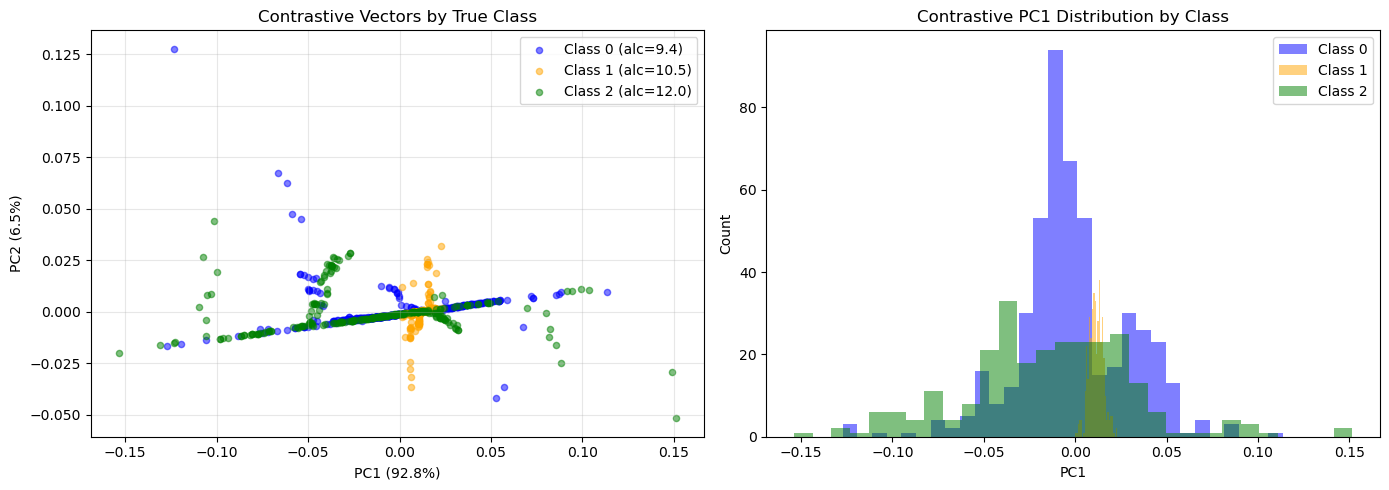

In [18]:
# =============================================================================
# CONTRASTIVE GRADIENT ANALYSIS
# =============================================================================
# 
# Key insight: Each gradient = signal + sample_specific_noise
# By computing grad(correct) - mean(grad(incorrect)), we cancel the common noise.
#
# For UNKNOWN samples: We enumerate all possibilities and pick the best match.

def compute_contrastive_analysis(trainer, DO, n_epochs_to_average=10):
    """
    Compute contrastive gradients: grad(correct) - mean(grad(incorrect))
    This should cancel sample-specific noise.
    
    Returns:
        - contrastive_vectors: Array of contrastive signals per sample
        - class_ids: Which class the correct hypothesis belongs to
    """
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    contrastive_vectors = []
    class_ids = []
    
    for sample_idx in range(n_samples):
        start = sample_idx * hyp_per_sample
        sample_grads = {}
        correct_class = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            grad_list = trainer.gradient_history.get(gid, [])
            
            if len(grad_list) >= n_epochs_to_average:
                avg_grad = np.mean(grad_list[-n_epochs_to_average:], axis=0)
                sample_grads[hyp_idx] = avg_grad
                
                if DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']:
                    correct_class = hyp_idx
        
        # Only process samples with complete gradients
        if correct_class is not None and len(sample_grads) == hyp_per_sample:
            correct_grad = sample_grads[correct_class]
            incorrect_grads = [g for c, g in sample_grads.items() if c != correct_class]
            incorrect_mean = np.mean(incorrect_grads, axis=0)
            
            # Contrastive signal: correct - incorrect_mean
            contrastive = correct_grad - incorrect_mean
            contrastive_vectors.append(contrastive)
            class_ids.append(correct_class)
    
    return np.array(contrastive_vectors), np.array(class_ids)


def analyze_contrastive_clustering(contrastive_vectors, class_ids, hyp_per_sample):
    """
    Analyze whether contrastive vectors cluster by true class.
    If they do, we can use them to identify correct hypotheses.
    """
    print("="*70)
    print("CONTRASTIVE GRADIENT ANALYSIS")
    print("="*70)
    
    print(f"\nSamples analyzed: {len(contrastive_vectors)}")
    print(f"Vector dimension: {contrastive_vectors.shape[1]}")
    
    hyp_values = hypothesis[0]
    
    # 1. Compute class centroids
    print("\n" + "-"*50)
    print("1. CLASS CENTROIDS FROM CONTRASTIVE VECTORS")
    print("-"*50)
    
    class_centroids = {}
    for c in range(hyp_per_sample):
        mask = class_ids == c
        if mask.sum() > 0:
            class_centroids[c] = np.mean(contrastive_vectors[mask], axis=0)
            print(f"  Class {c} (alc={hyp_values[c]:.1f}): {mask.sum()} samples, magnitude={np.linalg.norm(class_centroids[c]):.6f}")
    
    # 2. Inter-class cosine similarities (should be low if classes distinct)
    print("\n" + "-"*50)
    print("2. INTER-CLASS COSINE SIMILARITIES")
    print("-"*50)
    
    for c1 in range(hyp_per_sample):
        for c2 in range(c1+1, hyp_per_sample):
            if c1 in class_centroids and c2 in class_centroids:
                sim = np.dot(class_centroids[c1], class_centroids[c2]) / (
                    np.linalg.norm(class_centroids[c1]) * np.linalg.norm(class_centroids[c2]) + 1e-8
                )
                print(f"  Class {c1} vs Class {c2}: {sim:.4f}")
    
    # 3. Within-class variance (should be low if contrastive removes noise)
    print("\n" + "-"*50)
    print("3. WITHIN-CLASS VARIANCE (lower = better)")
    print("-"*50)
    
    for c in range(hyp_per_sample):
        mask = class_ids == c
        if mask.sum() > 1:
            class_vecs = contrastive_vectors[mask]
            variance = np.mean(np.var(class_vecs, axis=0))
            print(f"  Class {c}: variance={variance:.6f}")
    
    # 4. Individual point alignment to class centroid
    print("\n" + "-"*50)
    print("4. POINT-TO-OWN-CENTROID ALIGNMENT")
    print("-"*50)
    
    alignments = []
    for c in range(hyp_per_sample):
        mask = class_ids == c
        if mask.sum() > 0 and c in class_centroids:
            class_vecs = contrastive_vectors[mask]
            centroid = class_centroids[c]
            
            sims = [np.dot(v, centroid) / (np.linalg.norm(v) * np.linalg.norm(centroid) + 1e-8)
                    for v in class_vecs]
            print(f"  Class {c}: mean={np.mean(sims):.4f}, std={np.std(sims):.4f}")
            alignments.extend(sims)
    
    print(f"\n  Overall: mean={np.mean(alignments):.4f}, std={np.std(alignments):.4f}")
    print(f"  (Compare to raw gradients: mean~0, std~0.45)")
    
    # 5. PCA visualization
    print("\n" + "-"*50)
    print("5. PCA VISUALIZATION")
    print("-"*50)
    
    pca = PCA(n_components=2)
    vecs_2d = pca.fit_transform(contrastive_vectors)
    
    print(f"  Explained variance: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: colored by class
    ax1 = axes[0]
    colors = ['blue', 'orange', 'green']
    
    for c in range(hyp_per_sample):
        mask = class_ids == c
        ax1.scatter(vecs_2d[mask, 0], vecs_2d[mask, 1], c=colors[c], alpha=0.5,
                   label=f'Class {c} (alc={hyp_values[c]:.1f})', s=20)
    
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax1.set_title('Contrastive Vectors by True Class')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right: histogram of PC1 by class
    ax2 = axes[1]
    for c in range(hyp_per_sample):
        mask = class_ids == c
        ax2.hist(vecs_2d[mask, 0], bins=30, alpha=0.5, label=f'Class {c}', color=colors[c])
    
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('Count')
    ax2.set_title('Contrastive PC1 Distribution by Class')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return class_centroids


# Run contrastive analysis
print("\n" + "="*70)
print("RUNNING CONTRASTIVE GRADIENT ANALYSIS")
print("="*70)

contrastive_vectors, contrastive_class_ids = compute_contrastive_analysis(trainer, DO, n_epochs_to_average=10)
class_centroids = analyze_contrastive_clustering(contrastive_vectors, contrastive_class_ids, hyp_per_sample)

In [19]:
# =============================================================================
# COMPARE CONTRASTIVE VS RAW GRADIENT SEPARATION
# =============================================================================

def compare_contrastive_vs_raw(trainer, DO, n_epochs_to_average=10):
    """
    Side-by-side comparison of raw gradient vs contrastive separation quality.
    """
    hyp_per_sample = DO.num_hyp_comb
    
    # Get raw gradients (from earlier analysis)
    raw_gradients = []
    raw_is_correct = []
    raw_class_ids = []
    
    for gid, grad_list in trainer.gradient_history.items():
        if len(grad_list) >= n_epochs_to_average:
            avg_grad = np.mean(grad_list[-n_epochs_to_average:], axis=0)
            raw_gradients.append(avg_grad)
            raw_is_correct.append(DO.df_train_hypothesis.iloc[gid]['correct_hypothesis'])
            raw_class_ids.append(DO.df_train_hypothesis.iloc[gid]['hyp_class_id'])
    
    raw_gradients = np.array(raw_gradients)
    raw_is_correct = np.array(raw_is_correct)
    raw_class_ids = np.array(raw_class_ids)
    
    # Get contrastive vectors (already computed)
    # contrastive_vectors, contrastive_class_ids already exist from previous cell
    
    print("="*70)
    print("COMPARISON: RAW GRADIENTS vs CONTRASTIVE")
    print("="*70)
    
    # 1. Point-to-centroid alignment
    print("\n1. POINT-TO-CENTROID ALIGNMENT (higher = better noise reduction)")
    print("-"*50)
    
    # Raw: correct vs incorrect
    correct_raw = raw_gradients[raw_is_correct]
    correct_centroid_raw = np.mean(correct_raw, axis=0)
    
    raw_alignments = [np.dot(g, correct_centroid_raw) / (np.linalg.norm(g) * np.linalg.norm(correct_centroid_raw) + 1e-8)
                      for g in correct_raw]
    
    print(f"  Raw gradients (correct to correct centroid):")
    print(f"    mean={np.mean(raw_alignments):.4f}, std={np.std(raw_alignments):.4f}")
    
    # Contrastive: each class to its centroid
    contrastive_alignments = []
    for c in range(hyp_per_sample):
        mask = contrastive_class_ids == c
        if mask.sum() > 0:
            centroid = np.mean(contrastive_vectors[mask], axis=0)
            class_alignments = [np.dot(v, centroid) / (np.linalg.norm(v) * np.linalg.norm(centroid) + 1e-8)
                               for v in contrastive_vectors[mask]]
            contrastive_alignments.extend(class_alignments)
    
    print(f"  Contrastive vectors (to class centroid):")
    print(f"    mean={np.mean(contrastive_alignments):.4f}, std={np.std(contrastive_alignments):.4f}")
    
    improvement = np.mean(contrastive_alignments) - np.mean(raw_alignments)
    print(f"\n  IMPROVEMENT: {improvement:+.4f} (positive = contrastive better)")
    
    # 2. Silhouette score
    print("\n2. SILHOUETTE SCORE (clustering quality)")
    print("-"*50)
    
    from sklearn.metrics import silhouette_score
    
    raw_silhouette = silhouette_score(raw_gradients, raw_is_correct.astype(int))
    contrastive_silhouette = silhouette_score(contrastive_vectors, contrastive_class_ids)
    
    print(f"  Raw (correct vs incorrect): {raw_silhouette:.4f}")
    print(f"  Contrastive (by true class): {contrastive_silhouette:.4f}")
    
    return {
        'raw_alignment': np.mean(raw_alignments),
        'contrastive_alignment': np.mean(contrastive_alignments),
        'raw_silhouette': raw_silhouette,
        'contrastive_silhouette': contrastive_silhouette
    }

# Run comparison
print("\n" + "="*70)
print("RAW VS CONTRASTIVE COMPARISON")
print("="*70)
comparison = compare_contrastive_vs_raw(trainer, DO)


RAW VS CONTRASTIVE COMPARISON
COMPARISON: RAW GRADIENTS vs CONTRASTIVE

1. POINT-TO-CENTROID ALIGNMENT (higher = better noise reduction)
--------------------------------------------------
  Raw gradients (correct to correct centroid):
    mean=-0.0016, std=0.4203
  Contrastive vectors (to class centroid):
    mean=0.3347, std=0.7606

  IMPROVEMENT: +0.3363 (positive = contrastive better)

2. SILHOUETTE SCORE (clustering quality)
--------------------------------------------------
  Raw (correct vs incorrect): 0.0005
  Contrastive (by true class): 0.0943


In [20]:
# =============================================================================
# CONTRASTIVE-BASED SELECTION FOR UNKNOWN SAMPLES
# =============================================================================
# 
# For unknown samples, we DON'T know which hypothesis is correct.
# Solution: Enumerate all possibilities and pick the best match to anchors.
#
# For each sample with hypotheses H0, H1, H2:
#   contrastive_if_H0_correct = grad(H0) - mean(grad(H1), grad(H2))
#   contrastive_if_H1_correct = grad(H1) - mean(grad(H0), grad(H2))
#   contrastive_if_H2_correct = grad(H2) - mean(grad(H0), grad(H1))
#
# Then compare each to class anchors and pick the best match.

def contrastive_selection(trainer, DO, class_centroids, n_epochs_to_average=10):
    """
    Select correct hypothesis using contrastive enumeration.
    
    For each sample:
    1. Compute contrastive vector assuming each hypothesis is correct
    2. Match each to its corresponding class anchor
    3. Select the hypothesis whose contrastive best matches its anchor
    
    Args:
        trainer: Phase1Trainer with gradient_history
        DO: DataOperator
        class_centroids: Dict of class_id -> centroid vector (from contrastive analysis)
        n_epochs_to_average: Number of epochs to average
    
    Returns:
        Selection results including precision
    """
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    correct_selections = 0
    total_selections = 0
    
    selection_details = []
    
    for sample_idx in range(n_samples):
        start = sample_idx * hyp_per_sample
        sample_grads = {}
        true_correct_class = None
        
        # Get gradients for all hypotheses in this sample
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            grad_list = trainer.gradient_history.get(gid, [])
            
            if len(grad_list) >= n_epochs_to_average:
                avg_grad = np.mean(grad_list[-n_epochs_to_average:], axis=0)
                sample_grads[hyp_idx] = avg_grad
                
                if DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']:
                    true_correct_class = hyp_idx
        
        # Skip if incomplete
        if len(sample_grads) != hyp_per_sample or true_correct_class is None:
            continue
        
        # Enumerate: compute contrastive assuming each hypothesis is correct
        scores = []
        for assumed_correct in range(hyp_per_sample):
            # Compute contrastive as if this hypothesis is correct
            correct_grad = sample_grads[assumed_correct]
            incorrect_grads = [g for c, g in sample_grads.items() if c != assumed_correct]
            incorrect_mean = np.mean(incorrect_grads, axis=0)
            contrastive = correct_grad - incorrect_mean
            
            # Score: similarity to the class anchor for this hypothesis
            if assumed_correct in class_centroids:
                anchor = class_centroids[assumed_correct]
                score = np.dot(contrastive, anchor) / (
                    np.linalg.norm(contrastive) * np.linalg.norm(anchor) + 1e-8
                )
            else:
                score = -np.inf
            
            scores.append((assumed_correct, score))
        
        # Select hypothesis with highest score
        selected_class = max(scores, key=lambda x: x[1])[0]
        is_correct = (selected_class == true_correct_class)
        
        if is_correct:
            correct_selections += 1
        total_selections += 1
        
        selection_details.append({
            'sample_idx': sample_idx,
            'true_class': true_correct_class,
            'selected_class': selected_class,
            'is_correct': is_correct,
            'scores': dict(scores)
        })
    
    precision = correct_selections / total_selections if total_selections > 0 else 0
    
    return {
        'precision': precision,
        'correct': correct_selections,
        'total': total_selections,
        'details': selection_details
    }


# Run contrastive-based selection
print("\n" + "="*70)
print("CONTRASTIVE-BASED SELECTION")
print("="*70)

selection_results = contrastive_selection(trainer, DO, class_centroids, n_epochs_to_average=10)

print(f"\nResults:")
print(f"  Total samples: {selection_results['total']}")
print(f"  Correct selections: {selection_results['correct']}")
print(f"  PRECISION: {selection_results['precision']*100:.1f}%")
print(f"  (Random baseline: {100/hyp_per_sample:.1f}%)")

# Build confusion matrix
print("\n" + "-"*50)
print("CONFUSION MATRIX (True vs Selected)")
print("-"*50)

confusion = np.zeros((hyp_per_sample, hyp_per_sample), dtype=int)
for detail in selection_results['details']:
    confusion[detail['true_class'], detail['selected_class']] += 1

print(f"\n      Selected →")
print(f"True ↓  ", end="")
for c in range(hyp_per_sample):
    print(f"  C{c}  ", end="")
print()

for true_c in range(hyp_per_sample):
    print(f"  C{true_c}    ", end="")
    for sel_c in range(hyp_per_sample):
        marker = "*" if true_c == sel_c else " "
        print(f"{confusion[true_c, sel_c]:4d}{marker} ", end="")
    print()

# Per-class precision
print("\n" + "-"*50)
print("PER-CLASS ANALYSIS")
print("-"*50)

for c in range(hyp_per_sample):
    true_count = (confusion[c, :].sum())
    correct_count = confusion[c, c]
    selected_count = confusion[:, c].sum()
    
    recall = correct_count / true_count if true_count > 0 else 0
    precision_c = correct_count / selected_count if selected_count > 0 else 0
    
    print(f"  Class {c} (alc={hypothesis[0][c]:.1f}):")
    print(f"    True count: {true_count}, Selected: {selected_count}")
    print(f"    Recall: {recall*100:.1f}%, Precision: {precision_c*100:.1f}%")


CONTRASTIVE-BASED SELECTION

Results:
  Total samples: 1151
  Correct selections: 544
  PRECISION: 47.3%
  (Random baseline: 33.3%)

--------------------------------------------------
CONFUSION MATRIX (True vs Selected)
--------------------------------------------------

      Selected →
True ↓    C0    C1    C2  
  C0     348*    7   127  
  C1     203     6*  198  
  C2      68     4   190* 

--------------------------------------------------
PER-CLASS ANALYSIS
--------------------------------------------------
  Class 0 (alc=9.4):
    True count: 482, Selected: 619
    Recall: 72.2%, Precision: 56.2%
  Class 1 (alc=10.5):
    True count: 407, Selected: 17
    Recall: 1.5%, Precision: 35.3%
  Class 2 (alc=12.0):
    True count: 262, Selected: 515
    Recall: 72.5%, Precision: 36.9%
